In [1]:
# -*- coding: utf-8 -*-

## 시작하기 전에

현재 사용하는 데이터의 라벨을 먼저 만들어야 한다.


#### label_generator
label_generator.py는 데이터셋을 clone하여 여러 개의 데이터를 만들었을 때, 새로운 데이터들의 라벨이 없을 때 사용한다.

해당 프로그램은 파일의 경로와 해당 파일의 라벨을 clone된 파일의 이름을 통해 매칭하여 새로운 (경로 라벨)구조의 csv 파일을 만들어낸다.

인자로 (이미지 파일이 담긴 폴더의 경로), (\[파일명, 라벨\]순으로 정리되있는 라벨 데이터)를 받고

-o 옵션을 통해 아웃풋 파일의 경로를 정의 가능하다


```py
    python -m label_generator ./augmentation names.txt -o labels.csv
```

## Constants Definition

In [2]:
from util.constants import *

## Load Util Functions

In [3]:
from util.utils import *

## Load Global Datas

In [4]:
image_paths, encoded_labels, label_classes = load_original_datas(DATA_PATH)
total_images_cnt = len(image_paths)  # 총 이미지 개수

## SIFT keypoint extraction

In [5]:
@timer("SIFT")
def sift():
    import cv2
    import h5py
    import numpy as np


    # Variables
    processed_images_cnt = 0  # 현재 처리한 이미지 개수
    descriptor_idx = 0 # 현재 descriptor index

    # Array Initialization
    keypoint_idx_cnt = np.ndarray(shape=(total_images_cnt, 2), dtype="int32")
    all_keypoints = np.ndarray(shape=(TOTAL_DESCRIPTOR_CNT, 7), dtype="float32")
    all_descriptors = np.ndarray(shape=(TOTAL_DESCRIPTOR_CNT, DESCRIPTOR_LENGTH), dtype="float32")
    
    # SIFT
    for image_index in range(total_images_cnt):
        image_path = image_paths[image_index]
        image_label = encoded_labels[image_index]

        original_image = cv2.imread(image_path)
        grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        sift = cv2.xfeatures2d.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(grayscale_image, None)

        # Descriptor가 없는 케이스에 대해 대처해야 함
        # keypoints가 None이 아니더라도, descriptors가 None이 되는 케이스가 있음
        # 따라서 descriptor == None을 체크
        if descriptors is not None:
            descriptors = descriptors.astype(np.float32, copy=False)
            descriptors = descriptors.reshape(-1, DESCRIPTOR_LENGTH)

            cur_keypoint_cnt = len(keypoints)
            descriptor_cnt = descriptors.shape[0]
            keypoint_idx_cnt[processed_images_cnt][0] = descriptor_idx
            keypoint_idx_cnt[processed_images_cnt][1] = descriptor_cnt
            if cur_keypoint_cnt != descriptor_cnt:
                print("!!!Keypoint cnt is diff from descriptor cnt!!!")
                print(cur_keypoint_cnt, " / ", descriptor_cnt)

            # 전체 keypoint, descriptor array에 값 채워넣기
            for keypoint, descriptor in zip(keypoints, descriptors):
                kp = keypoint
                kp_serialized = (kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
                all_keypoints[descriptor_idx, :] = kp_serialized
                all_descriptors[descriptor_idx, :] = descriptor
                descriptor_idx += 1

        processed_images_cnt += 1
        if processed_images_cnt % 1000 == 0:
            print("[SIFT]{:>6d}/{:>6d}".format(processed_images_cnt, total_images_cnt))

    # 데이터 저장
    keypoint_info_file = h5py.File(SIFT_KEYPOINT_INFO_PATH, 'w')
    keypoint_info_file.create_dataset('keypoint_info', data=keypoint_idx_cnt)

    keypoint_file = h5py.File(SIFT_KEYPOINT_PATH, 'w')
    keypoint_file.create_dataset("keypoints", data=all_keypoints)
    
    descriptor_file = h5py.File(SIFT_DESCRIPTOR_PATH, 'w')
    descriptor_file.create_dataset("descriptors", data=all_descriptors)

In [6]:
sift()

[SIFT]-----Begin-----
[SIFT]  1000/  9191
[SIFT]  2000/  9191
[SIFT]  3000/  9191
[SIFT]  4000/  9191
[SIFT]  5000/  9191
[SIFT]  6000/  9191
[SIFT]  7000/  9191
[SIFT]  8000/  9191
[SIFT]  9000/  9191
[SIFT]-----End-----
[SIFT]Done in 153.97507238388062s


## Load SIFT processed data

In [7]:
from util.sift_data import SiftData

sift_data_paths = (SIFT_KEYPOINT_INFO_PATH, SIFT_KEYPOINT_PATH, SIFT_DESCRIPTOR_PATH)
sift_data = SiftData(sift_data_paths)

## kNN Classification

In [8]:
@timer("kNN")
def knn():
    import numpy as np
    from sklearn.neighbors import KNeighborsClassifier


    features = sift_data.summed_descriptors
    labels = np.copy(encoded_labels)
    
    # Shuffle Data
    seed = 1234
    np.random.seed(seed)
    np.random.shuffle(features)
    np.random.seed(seed)
    np.random.shuffle(labels)

    train_ratio = 0.8
    train_set_cnt = int(features.shape[0] * train_ratio)
    train_datas, test_datas = np.split(features, [train_set_cnt])
    train_labels, test_labels = np.split(labels, [train_set_cnt])

    def check_kNN_test_result(k):
        types = ["TRAIN", "TEST"]
        datas = [train_datas, test_datas]
        labels = [train_labels, test_labels]
        
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_datas, train_labels)

        for i in range(len(types)):
            test_type = types[i]
            test_data = datas[i]
            test_label = labels[i]

            correct = 0
            total = len(test_data)
            for idx in range(total):
                current_data = test_data[idx].reshape(1, -1)
                current_label = test_label[idx]

                predicted = model.predict(current_data)[0]
                if predicted == current_label:
                    correct += 1
            accuracy = 100 * correct / total
            print("[k={}][{}]{:5}/{:5}({:.4f}%)".format(k, test_type, correct, total, accuracy))

    for i in range(6):
        k = i * 2 + 1
        check_kNN_test_result(k)

In [9]:
knn()

[kNN]-----Begin-----
[k=1][TRAIN] 7352/ 7352(100.0000%)
[k=1][TEST] 1649/ 1839(89.6683%)
[k=3][TRAIN] 6996/ 7352(95.1578%)
[k=3][TEST] 1627/ 1839(88.4720%)
[k=5][TRAIN] 6806/ 7352(92.5734%)
[k=5][TEST] 1609/ 1839(87.4932%)
[k=7][TRAIN] 6684/ 7352(90.9140%)
[k=7][TEST] 1589/ 1839(86.4057%)
[k=9][TRAIN] 6591/ 7352(89.6491%)
[k=9][TEST] 1549/ 1839(84.2306%)
[k=11][TRAIN] 6478/ 7352(88.1121%)
[k=11][TEST] 1531/ 1839(83.2518%)
[kNN]-----End-----
[kNN]Done in 55.756920337677s


## k-means Clustering

In [10]:
import time
from sklearn.cluster import KMeans


kmeans_k = 8

print("[k-means]-----Begin-----")
# 타이머 적용 불가(KMeans의 인스턴스가 사라짐)
# 때문에, 직접 시간 측정
time_start = time.time()
kmeans_model = KMeans(n_clusters=kmeans_k).fit(sift_data.all_descriptors)
time_end = time.time()
time_diff = time_end - time_start

print("[k-means]Done in {}s".format(time_diff))

[k-means]-----Begin-----
[k-means]Done in 192.20357513427734s


## Visualization

#### 각 클래스별 descriptor 개수가 가장 많은 이미지를 k-means 클러스터별로 시각화

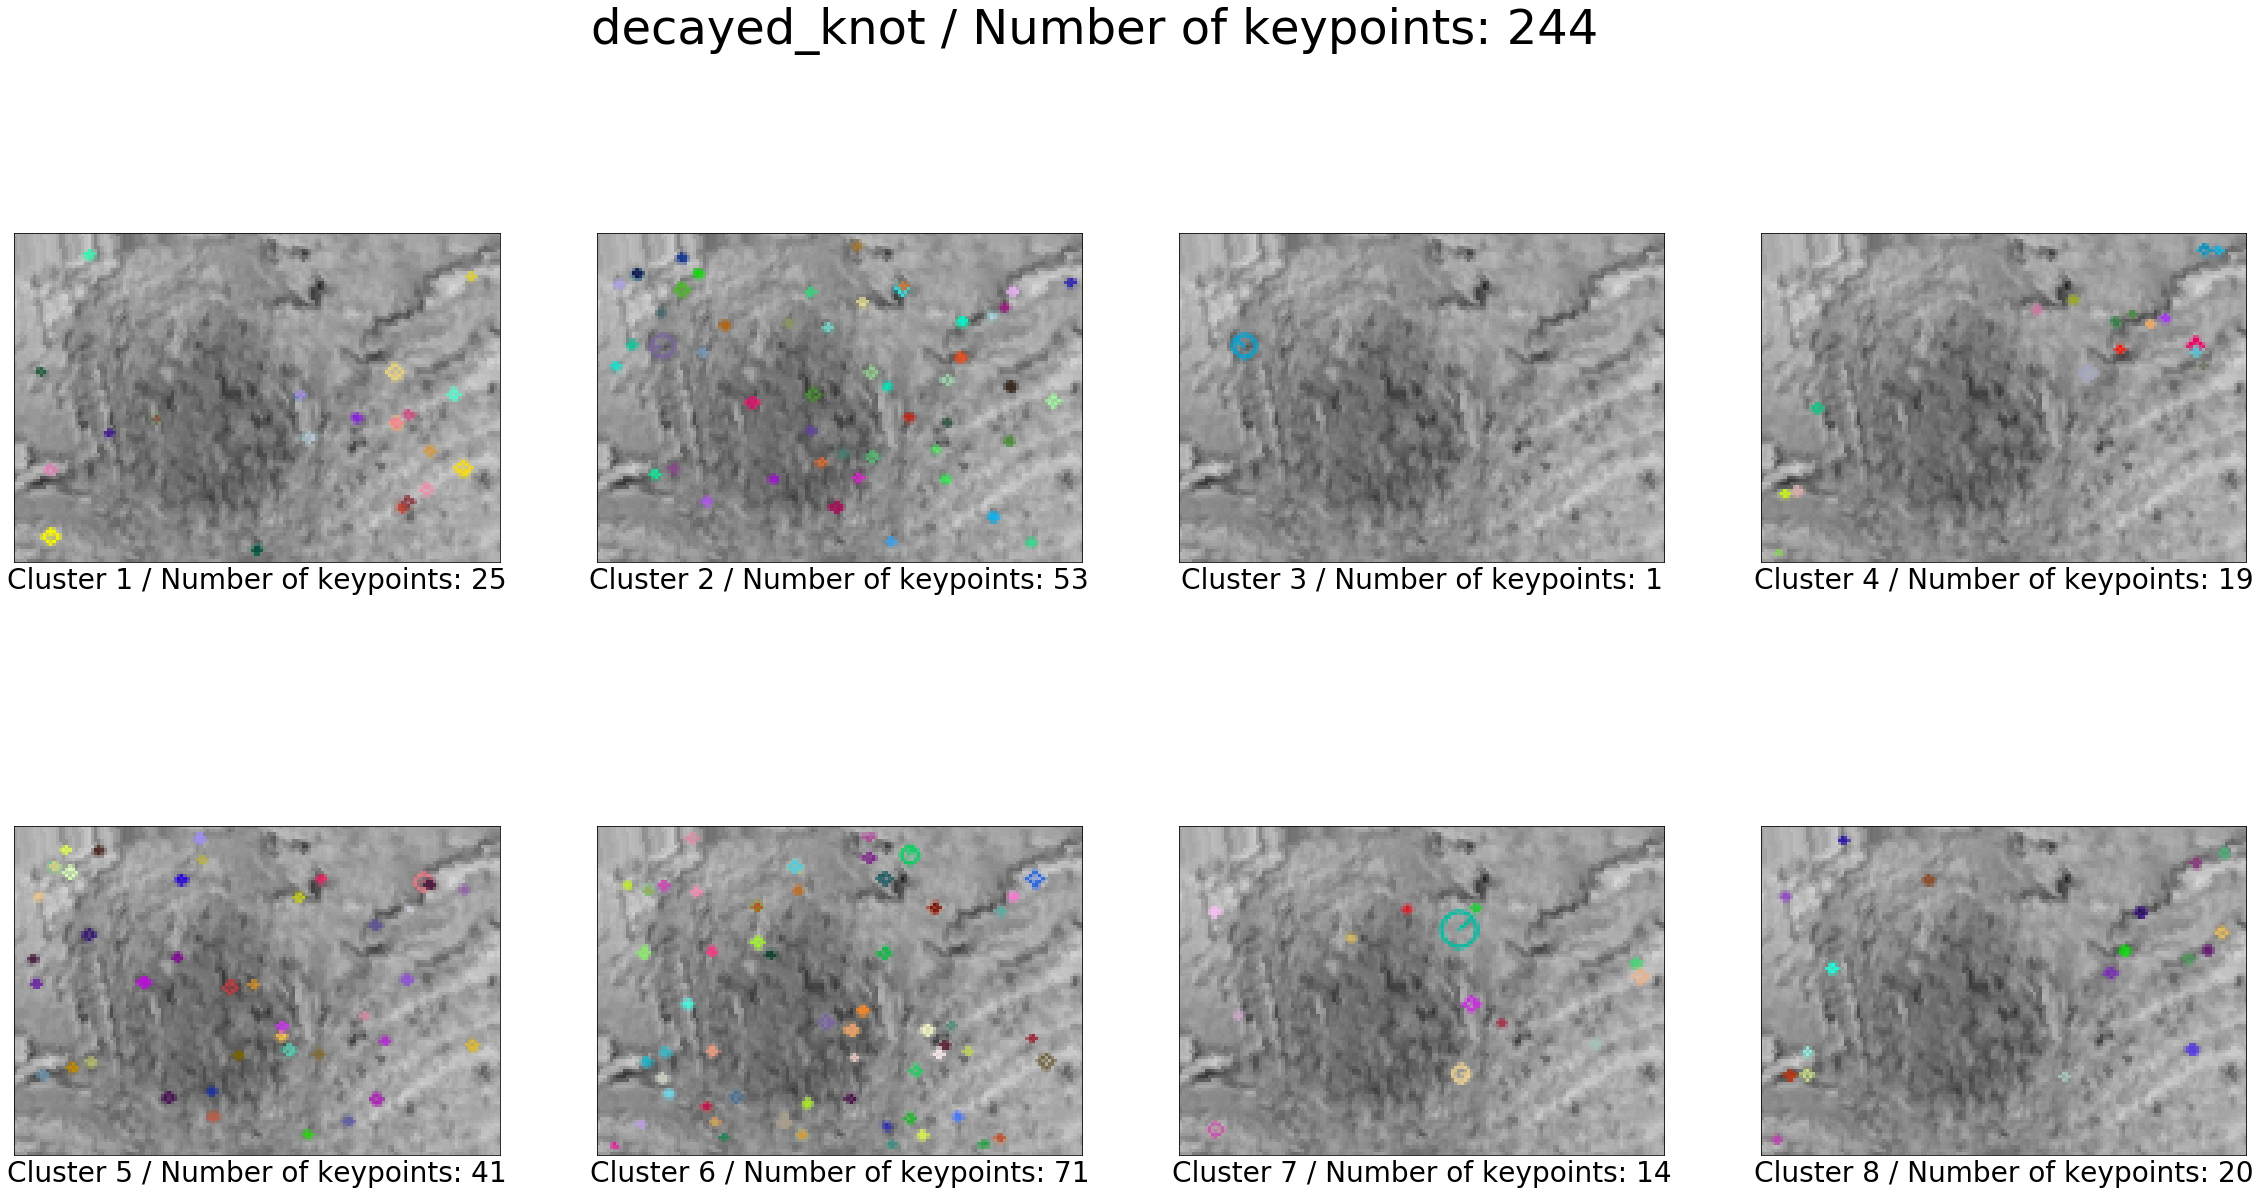

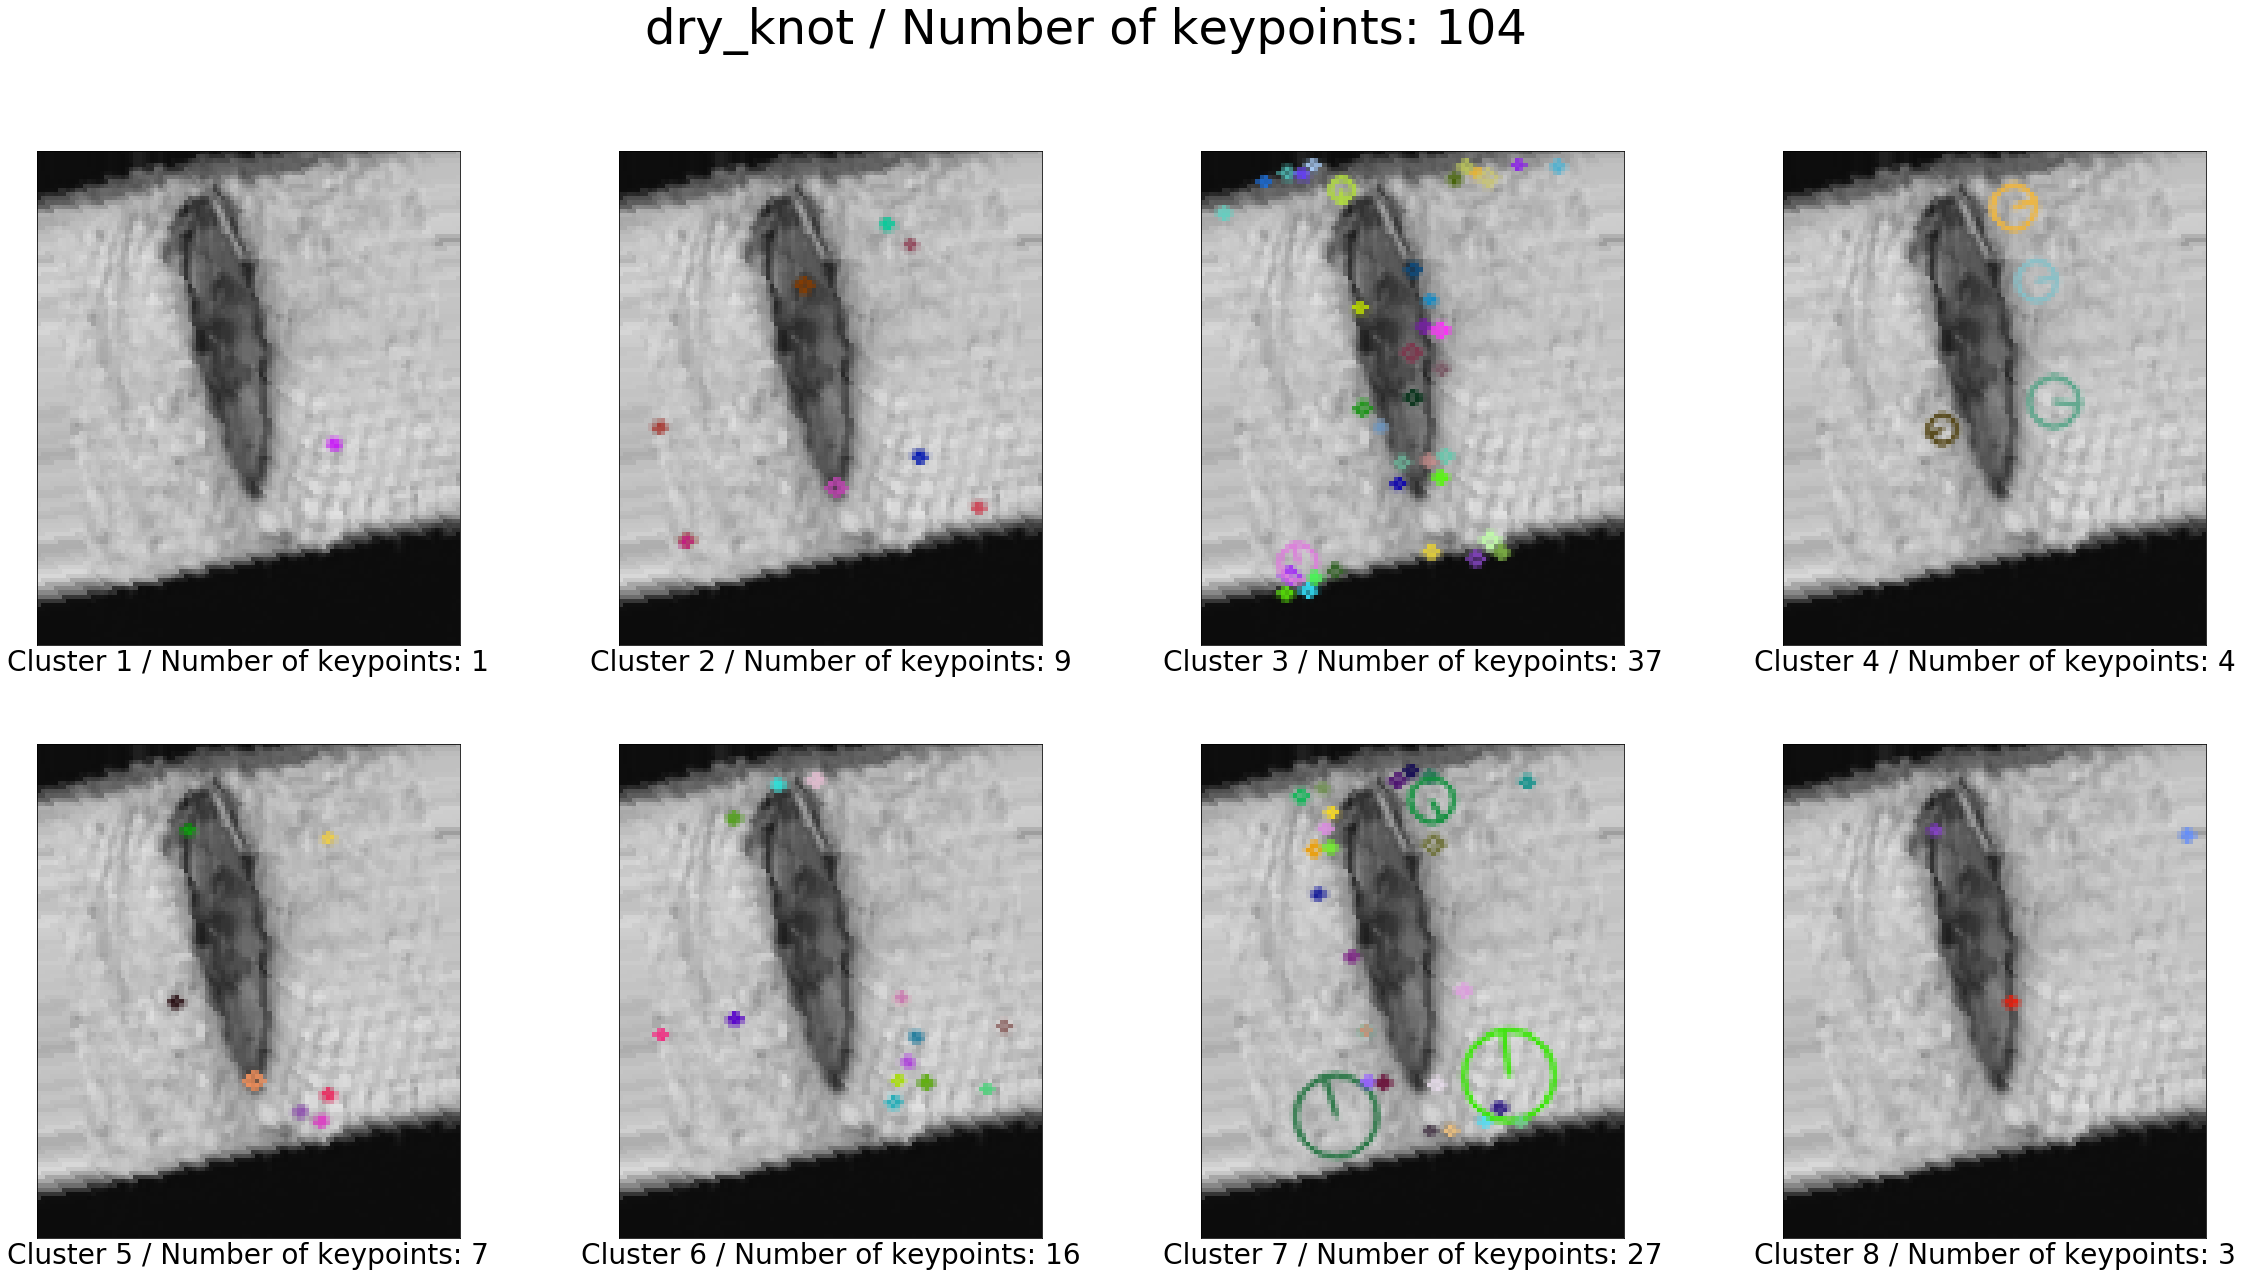

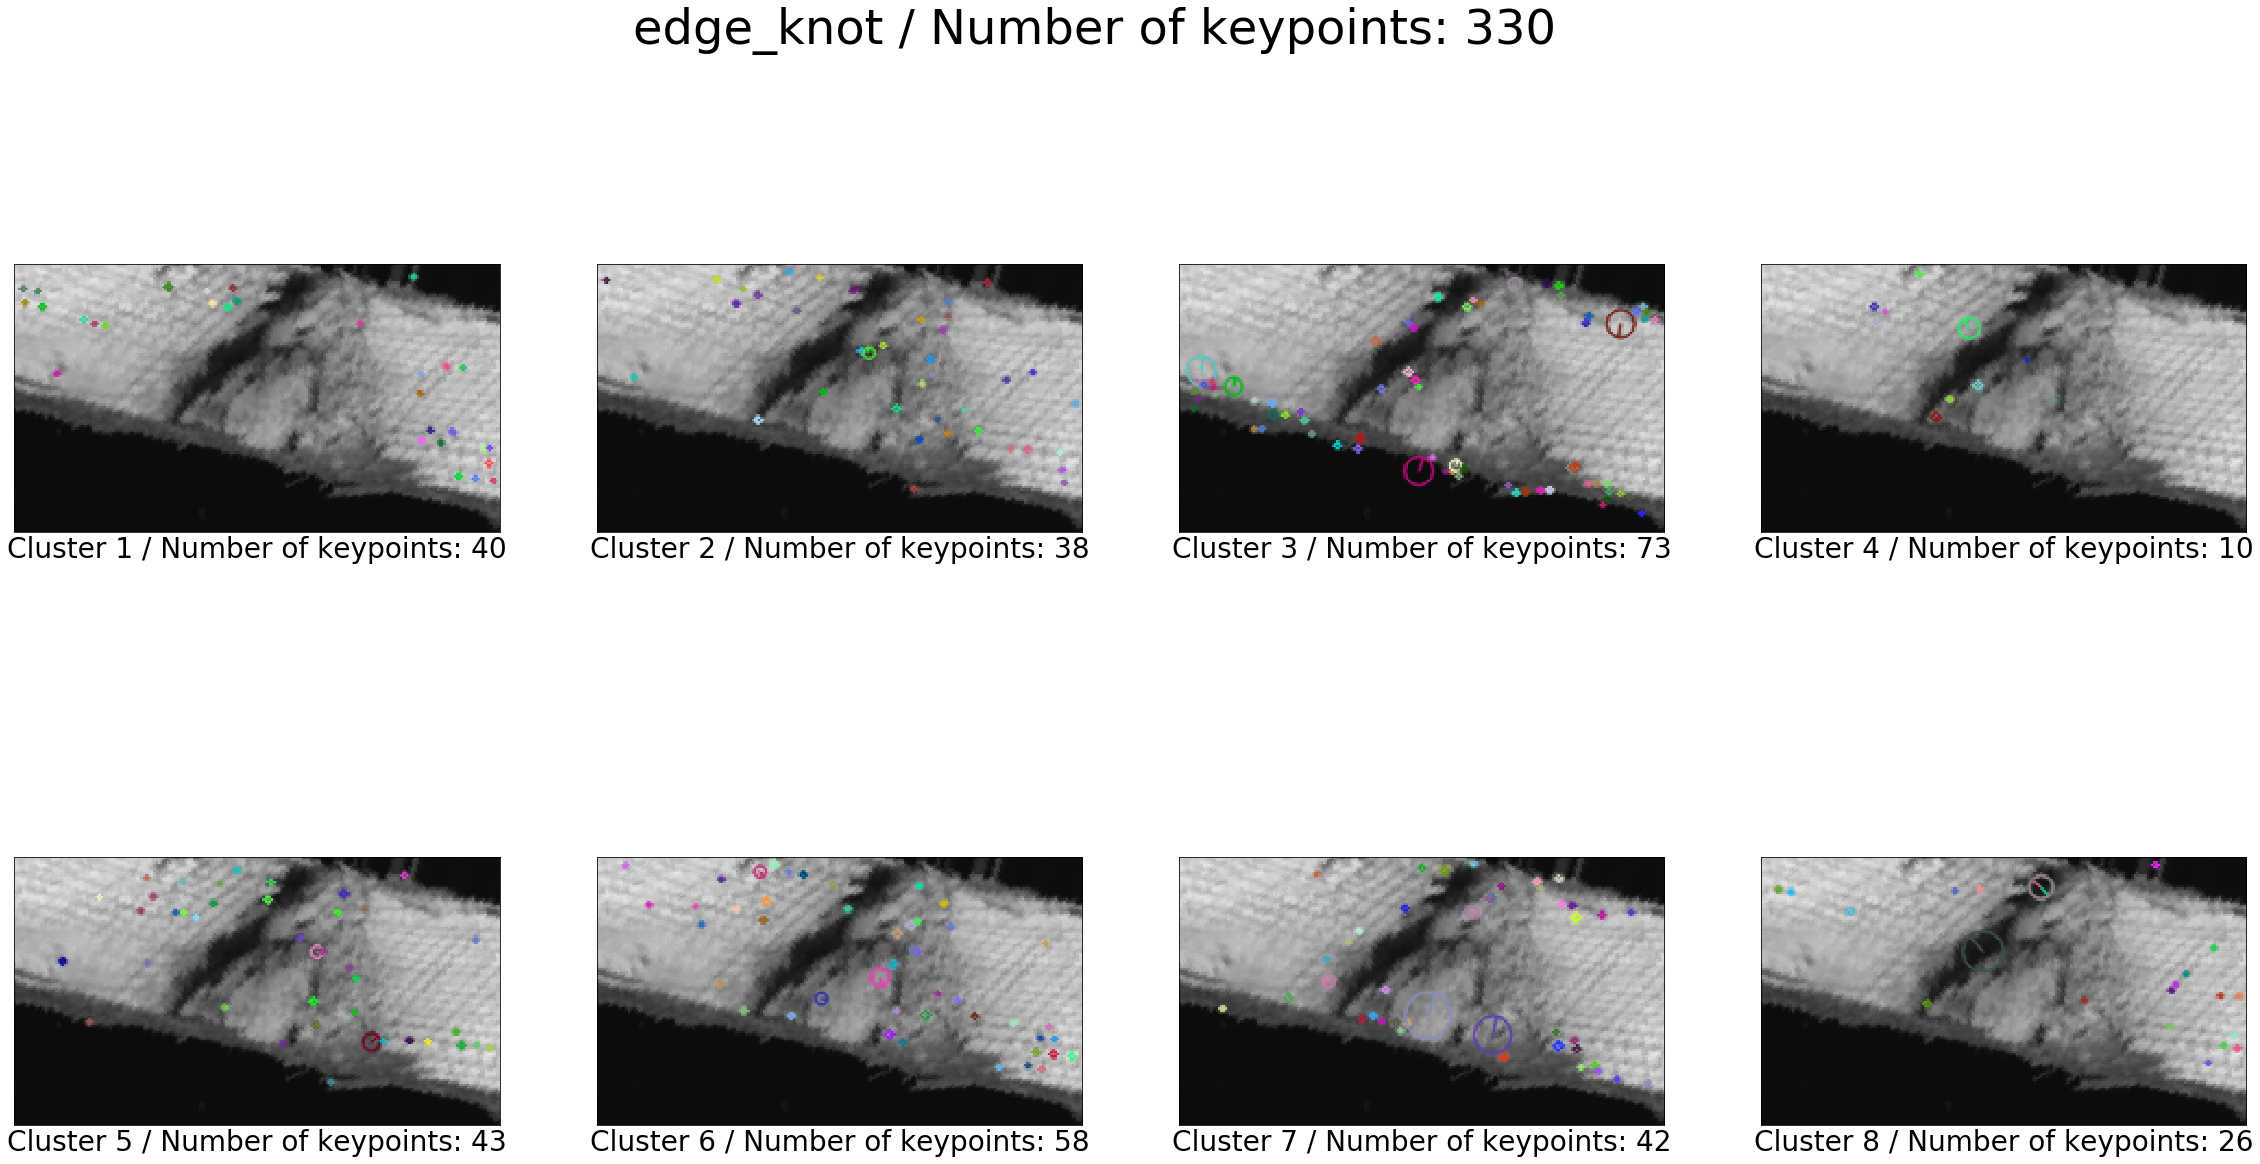

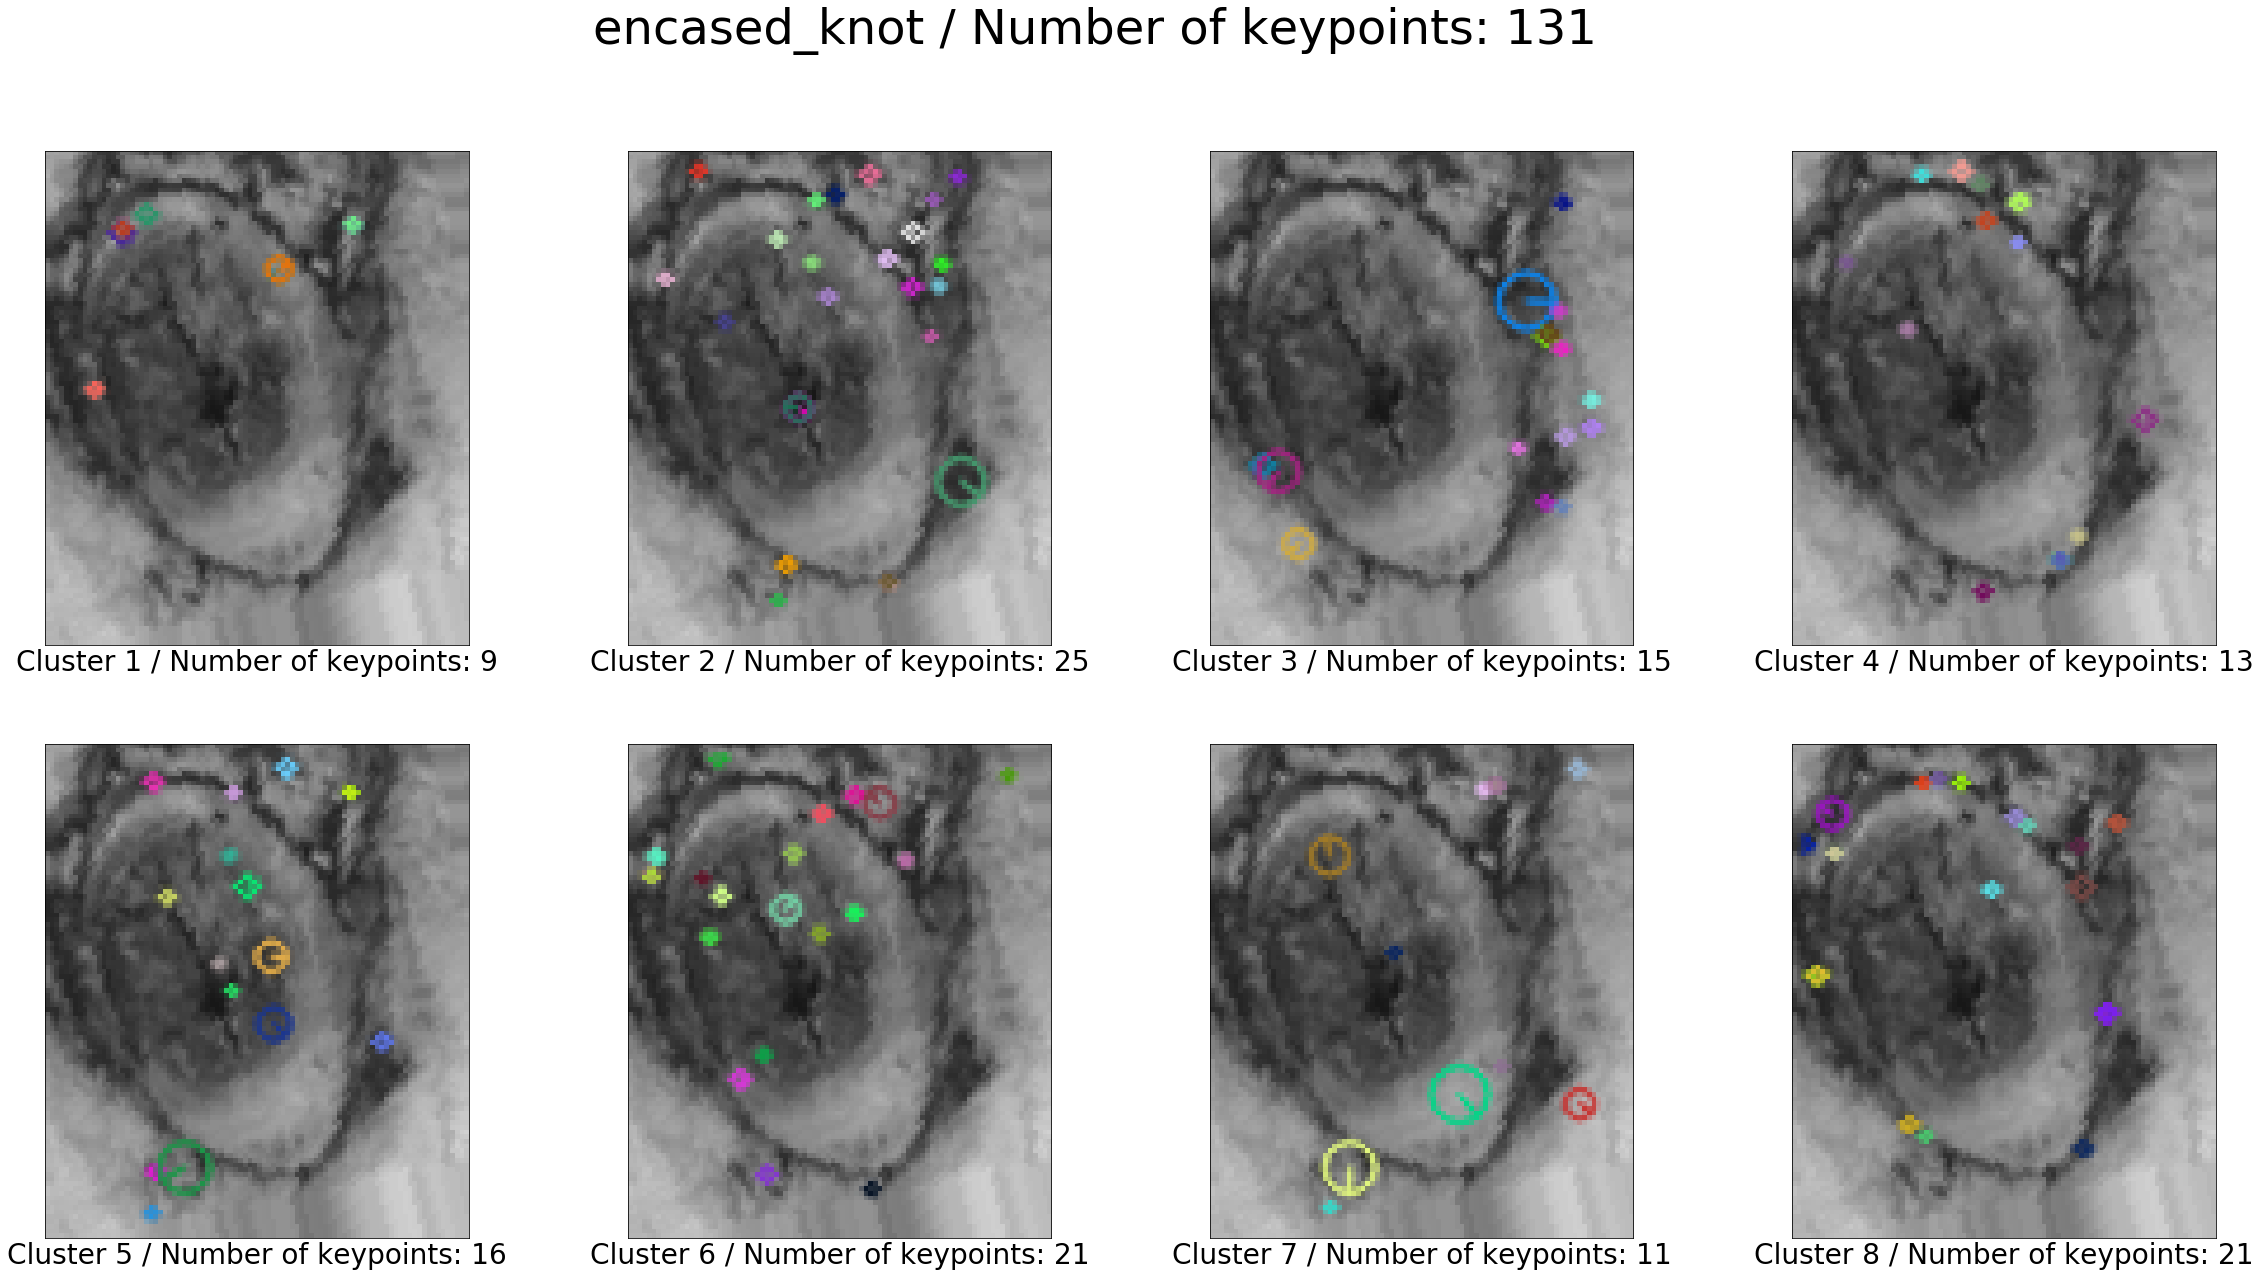

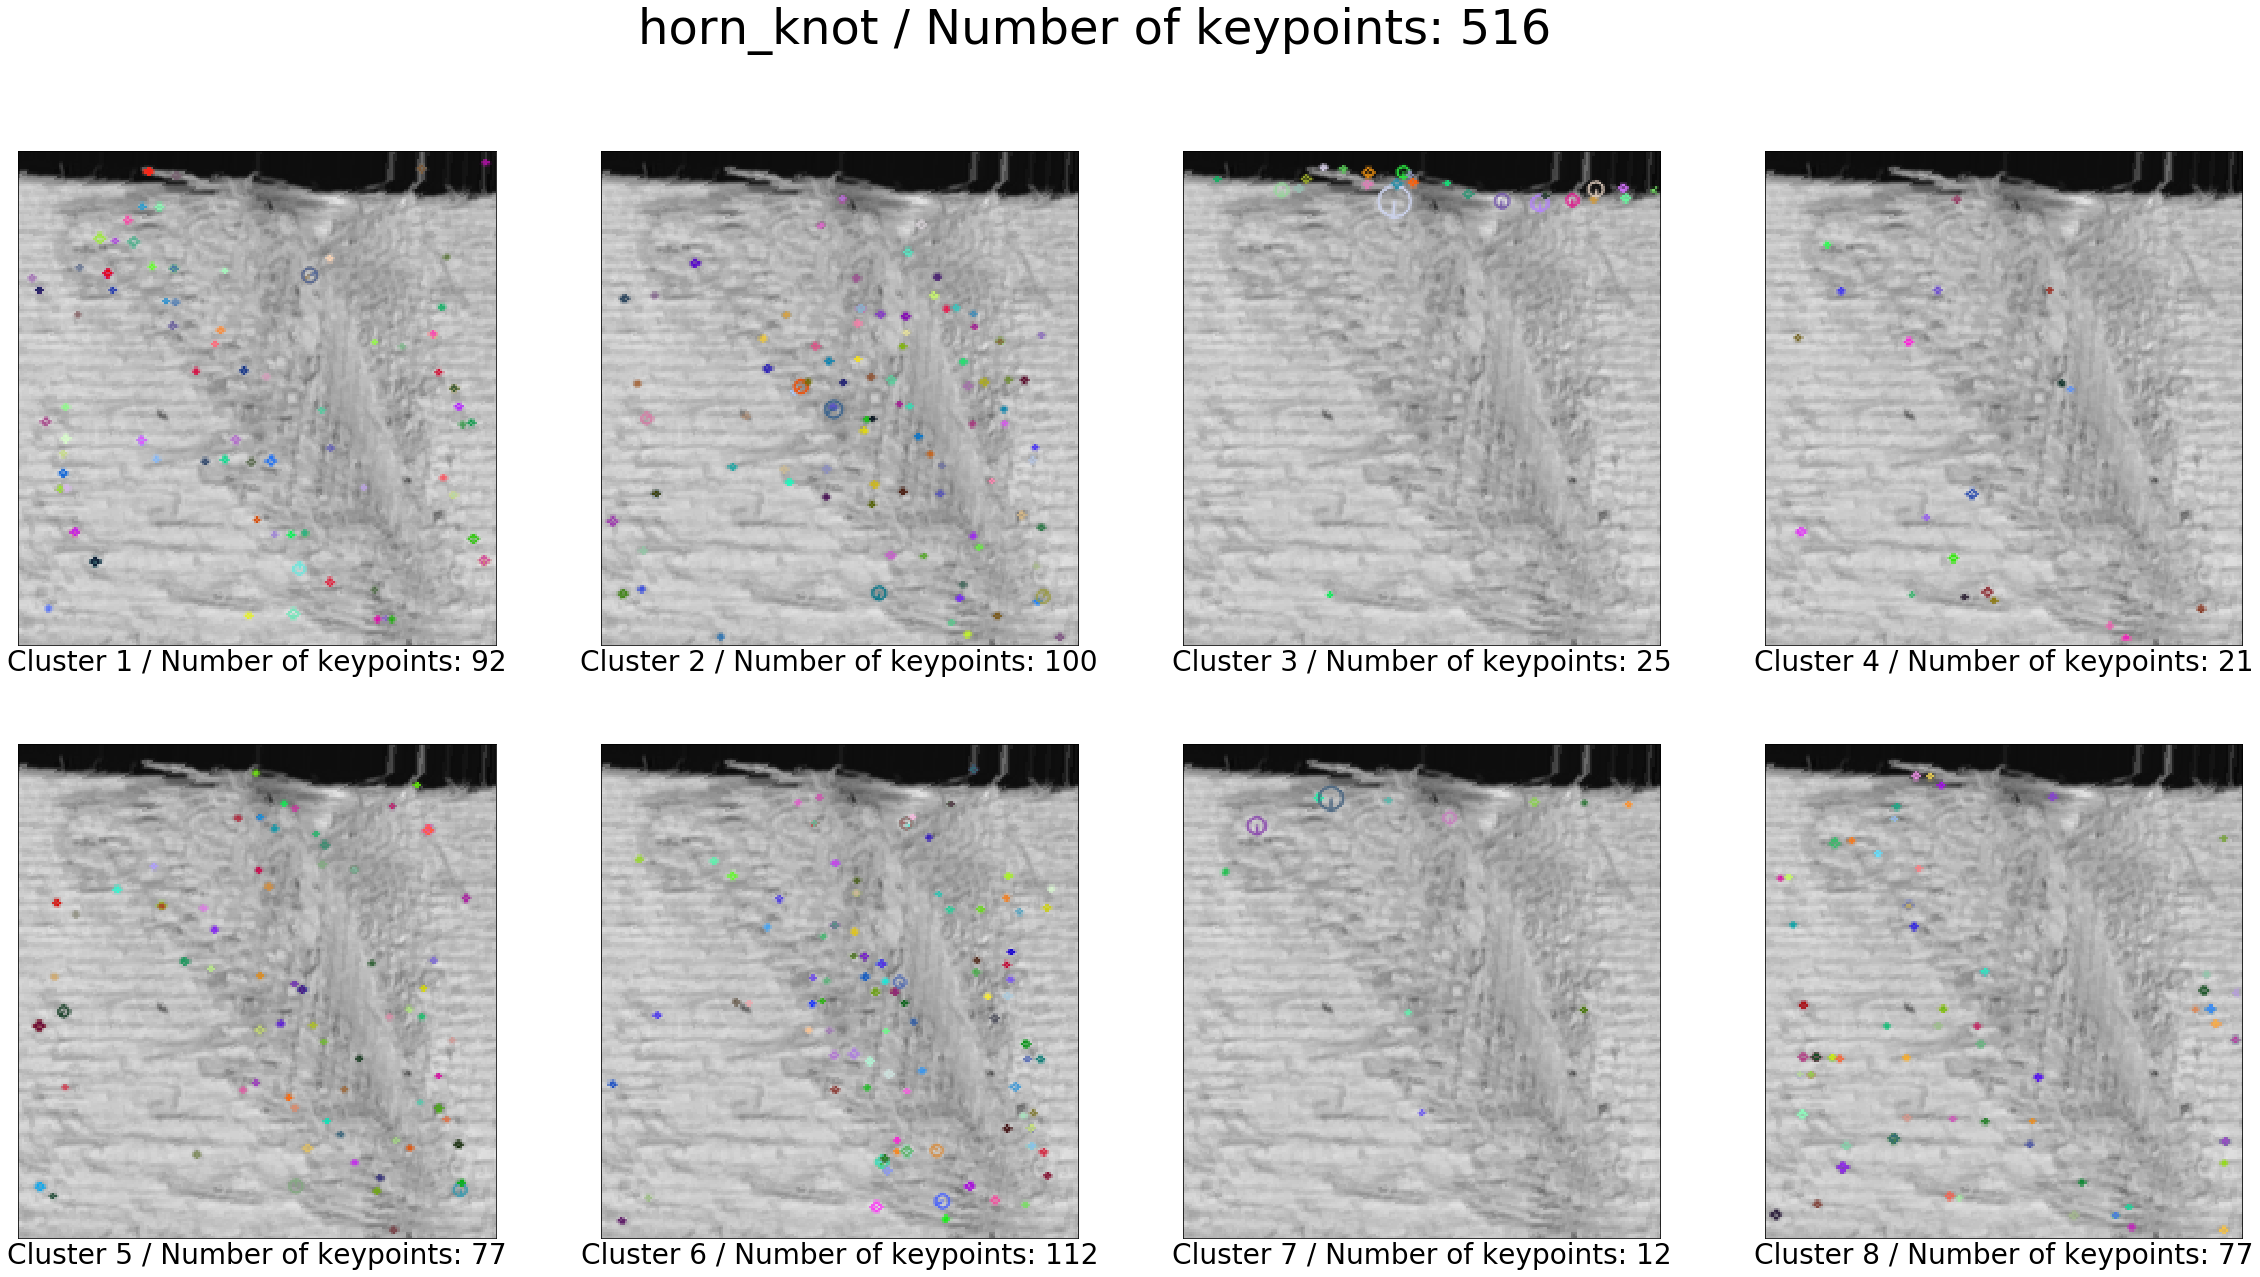

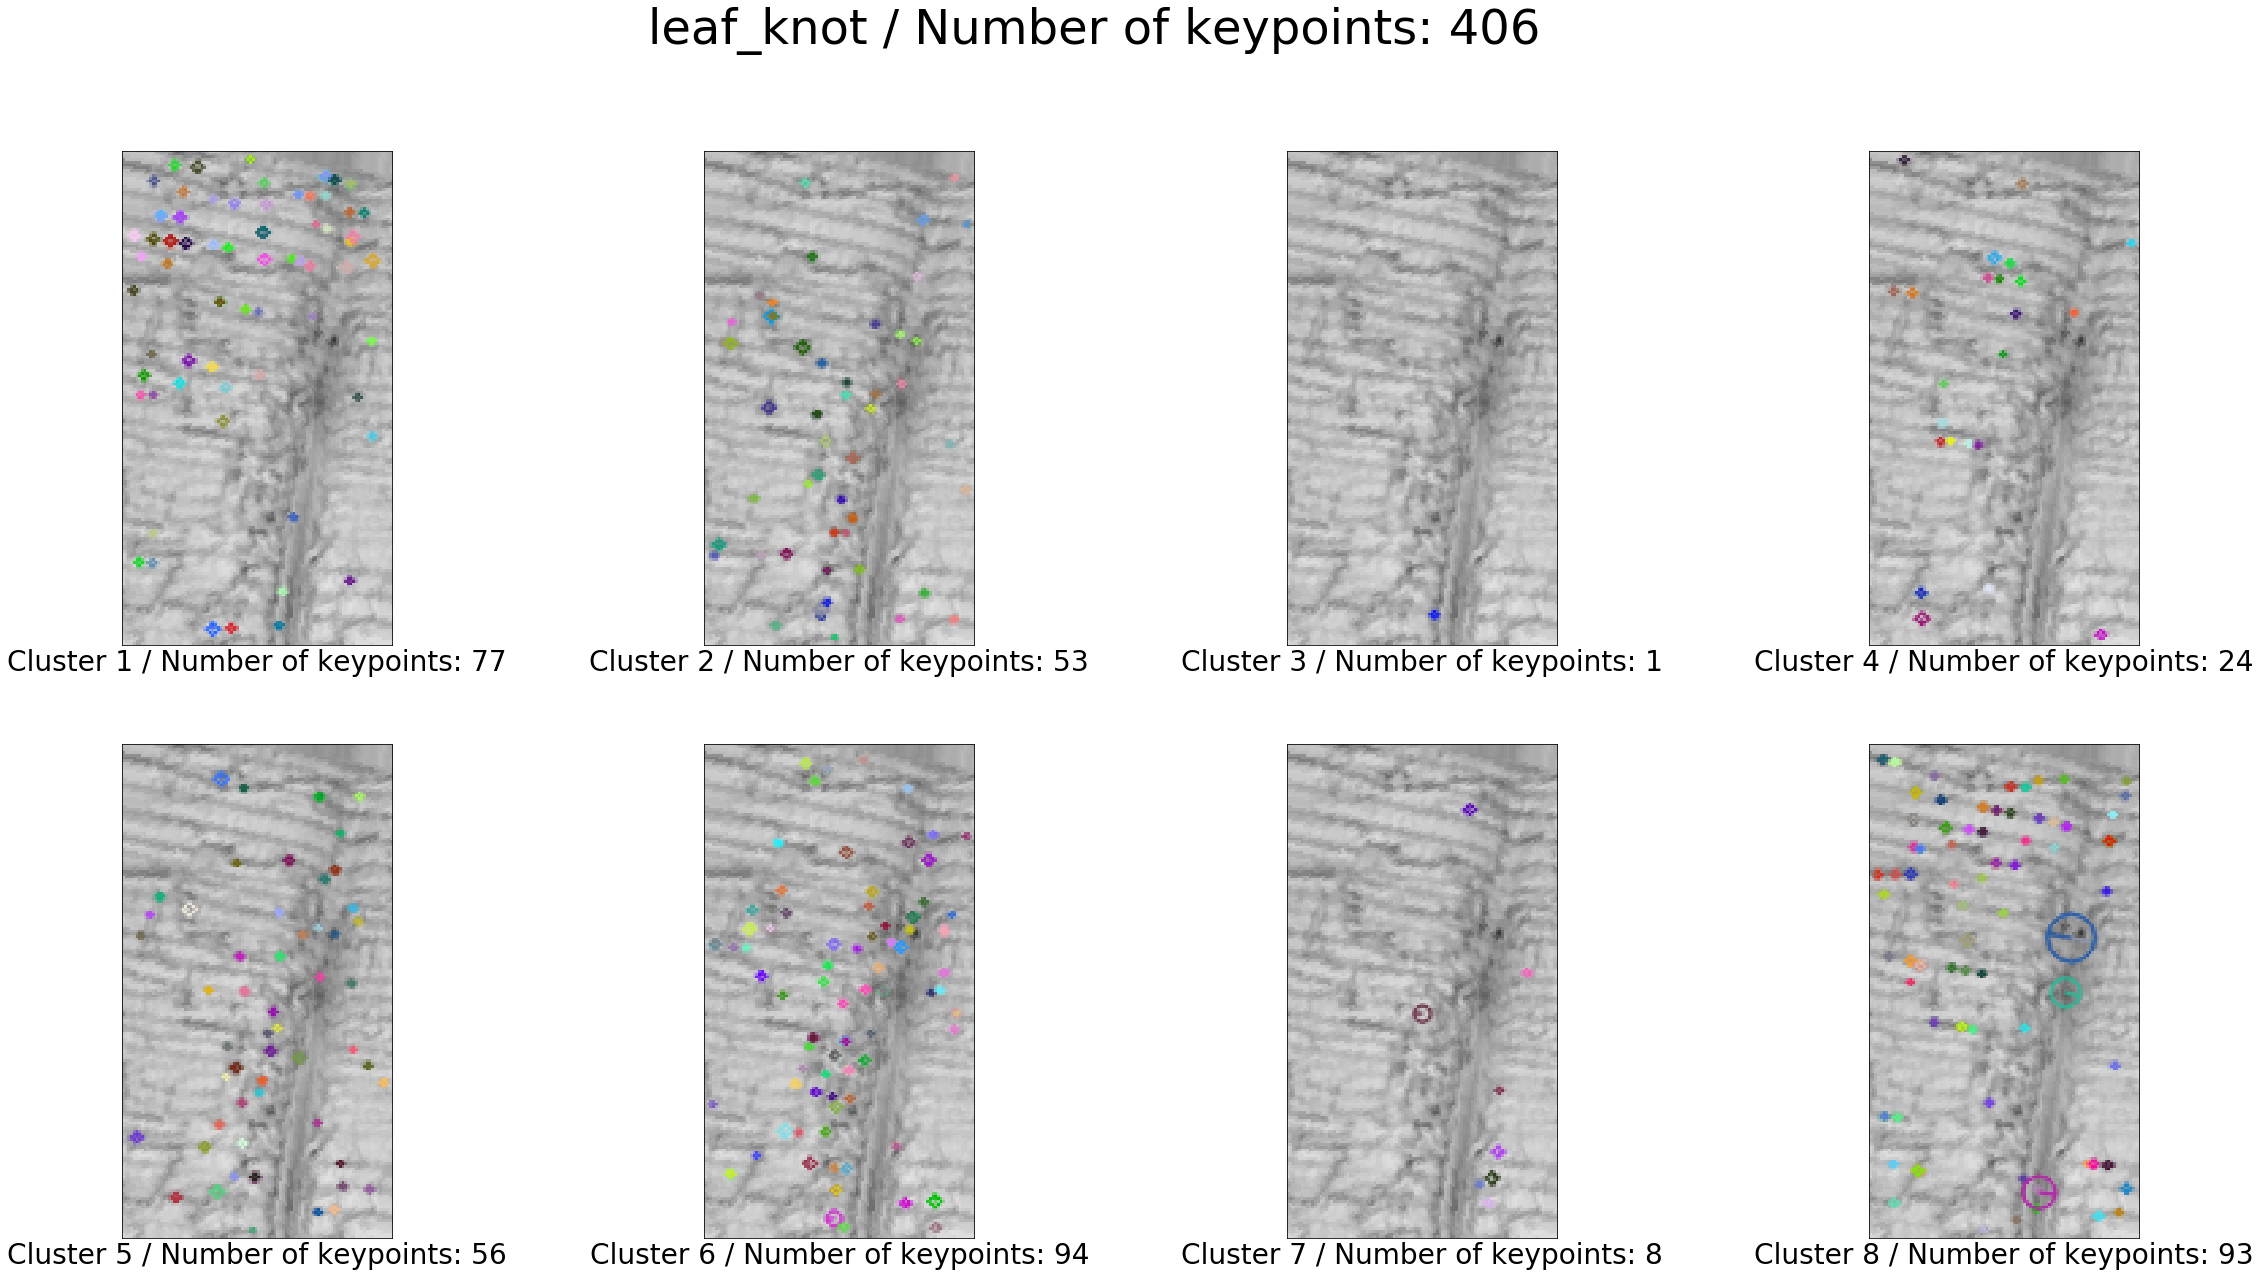

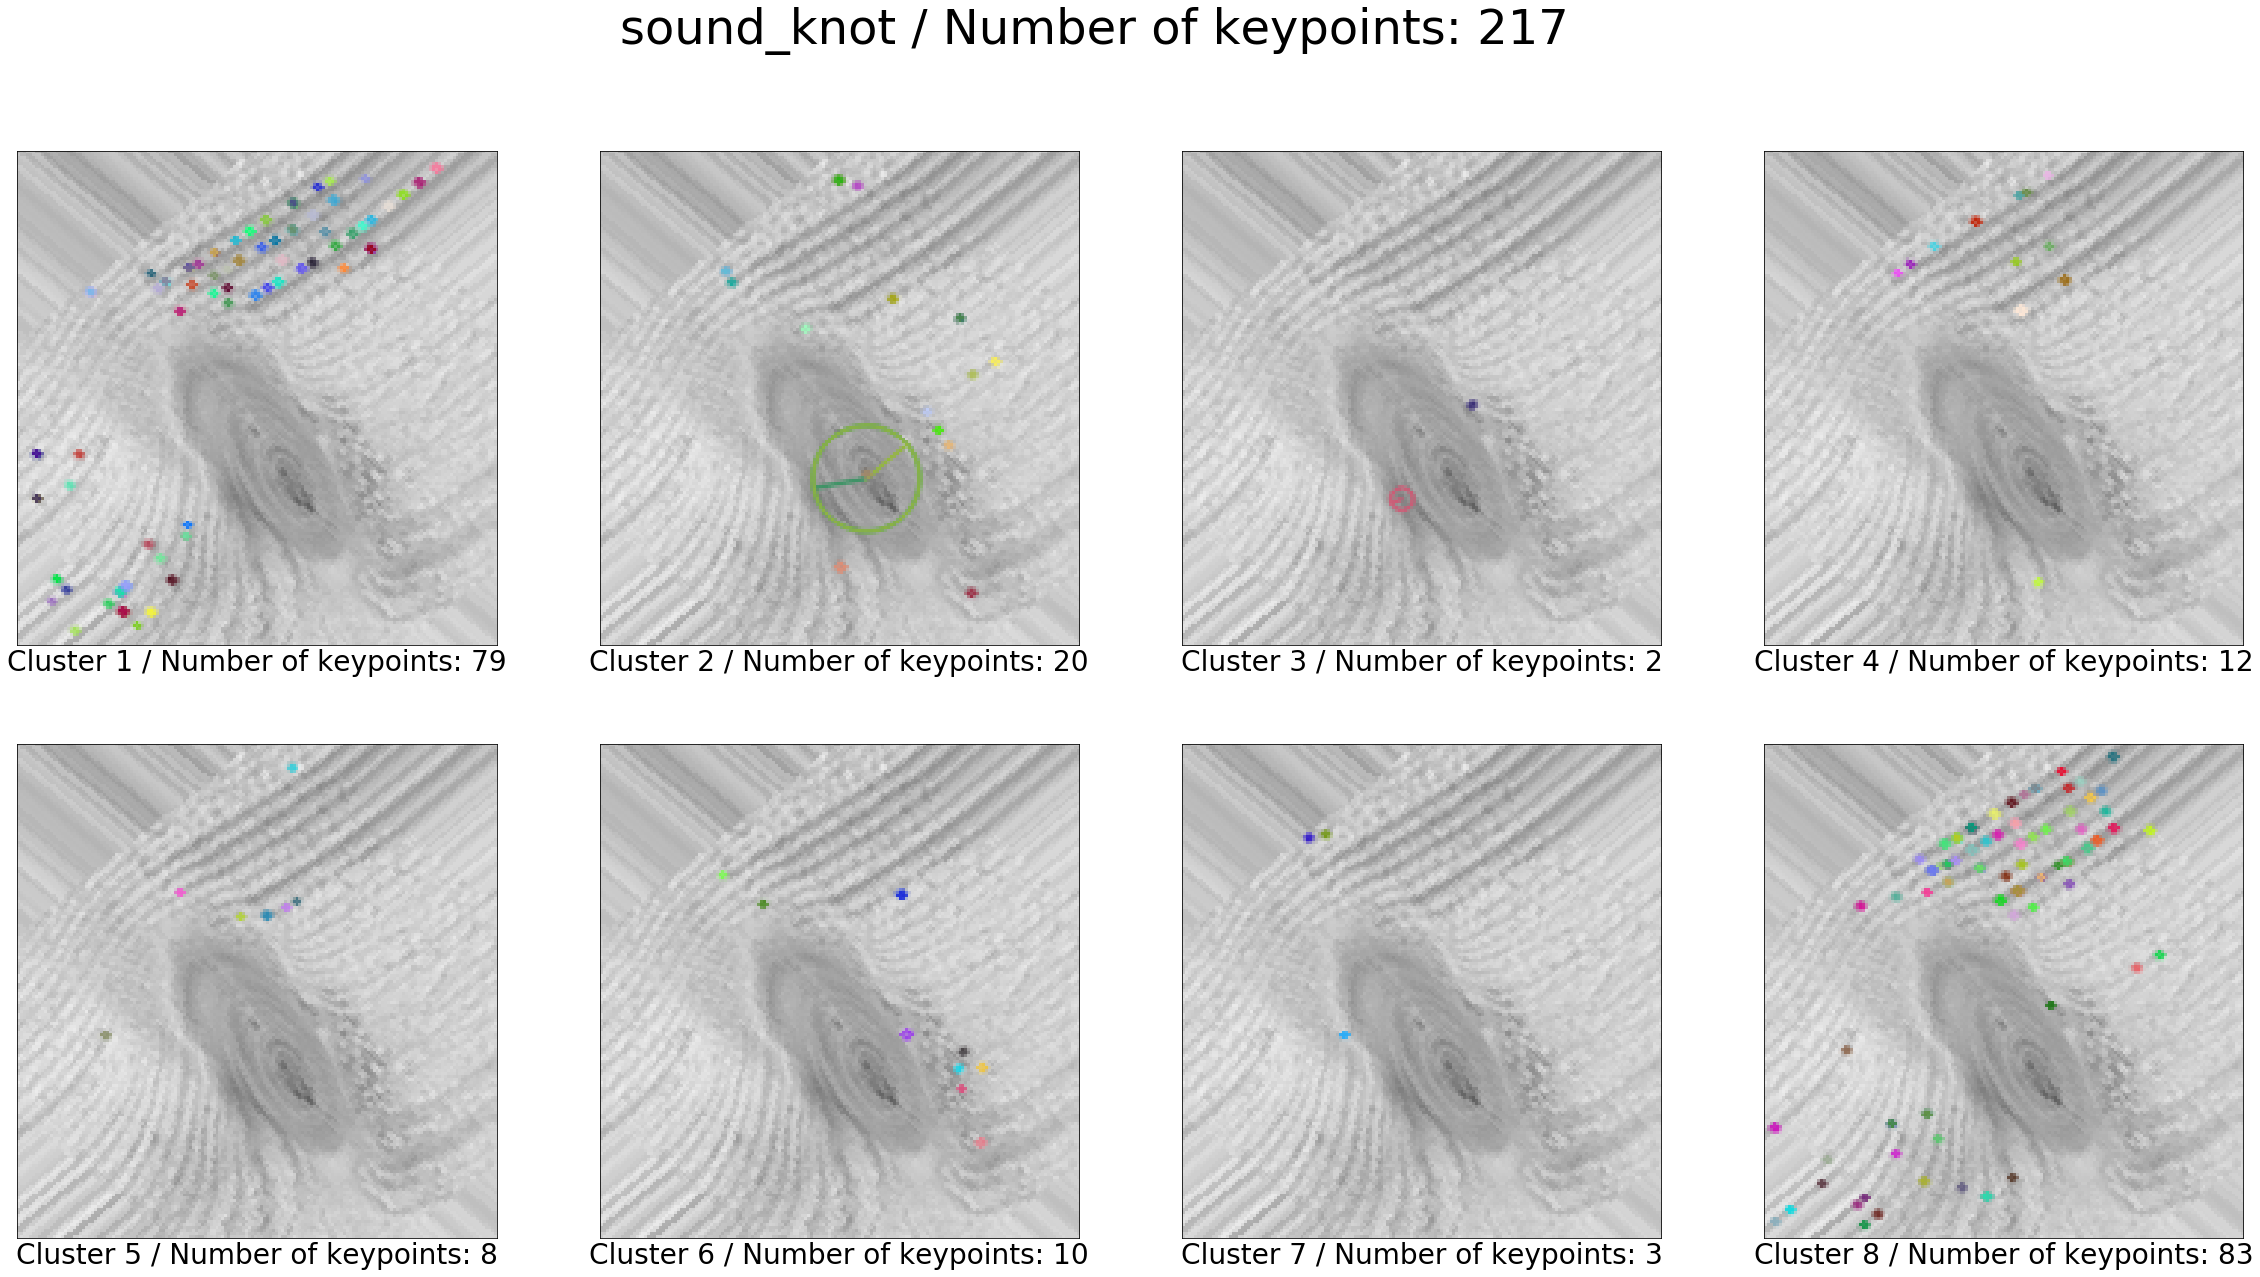

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


most_descriptor_cnt = np.zeros(shape=(CLASS_NUM), dtype="int32")
most_descriptor_idx = np.zeros(shape=(CLASS_NUM), dtype="int32")

for i in range(total_images_cnt):
    current_label = encoded_labels[i]
    keypoint_length = sift_data.keypoints_length_of(i)
    if keypoint_length > most_descriptor_cnt[current_label]:
        most_descriptor_cnt[current_label] = keypoint_length
        most_descriptor_idx[current_label] = i

for image_idx in most_descriptor_idx:
    image_path = image_paths[image_idx]
    image_label_str = label_classes[encoded_labels[image_idx]]
    original_image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    keypoints = sift_data.keypoints_of(image_idx)
    descriptors = sift_data.descriptors_of(image_idx)
    
    fig = plt.figure(figsize=(40, 20))
    for i in range(kmeans_k):
        if descriptors is not None:
            filtered_keypoints = []
            for j in range(descriptors.shape[0]):
                keypoint = keypoints[j]
                descriptor = descriptors[j]
                descriptor = descriptor.reshape(1, DESCRIPTOR_LENGTH)
                
                if kmeans_model.predict(descriptor) == i:
                    filtered_keypoints.append(keypoint)
            kmeans_img = cv2.drawKeypoints(grayscale_image, filtered_keypoints, outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        else:
            kmeans_img = original_image
        fig.add_subplot(2, 4, i + 1)
        plt.imshow(kmeans_img)
        plt.xticks([]), plt.yticks([])
        plt.xlabel("Cluster {} / Number of keypoints: {}".format(i + 1, len(filtered_keypoints)), fontsize=28)
    plt.suptitle('{} / Number of keypoints: {}'.format(image_label_str, descriptors.shape[0]), fontsize=48)
    plt.show()

#### 클래스별 descriptor의 클러스터별 분포도 시각화

[DESCRIPTOR K-MEANS PREDICTION]-----Begin-----
[DESCRIPTOR K-MEANS PREDICTION]-----End-----
[DESCRIPTOR K-MEANS PREDICTION]Done in 123.05681705474854s
[[ 1708  3738  1545  1145  3360  4541  2404  1984]
 [ 1907  5382  3528  3947  3411  4219  5403  4846]
 [ 4424  8544 17486  3843  7958  8433 10129  7022]
 [  916  2553  3520  3052  2122  2673  2423  2929]
 [14186 16990  9207  8332 13917 19325  5332 28394]
 [16573 15228  1043  6714 12729 19417  3195 24293]
 [ 6682 17815  8137  5243 13194 13294 13624  9458]]


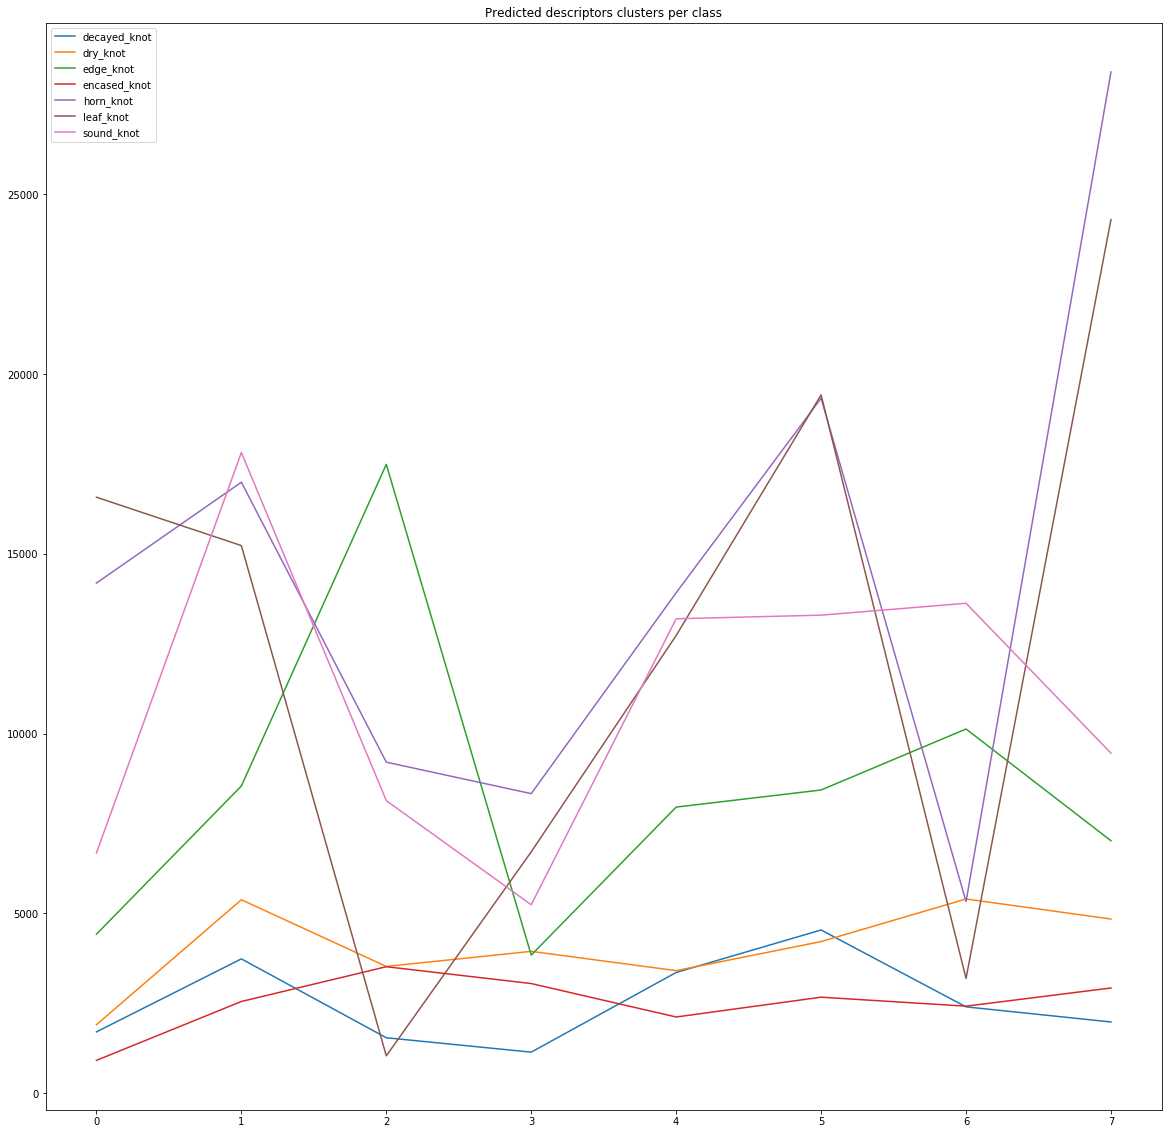

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


cluster_per_class = np.zeros(shape=(CLASS_NUM, kmeans_k), dtype="int32")

@timer("DESCRIPTOR K-MEANS PREDICTION")
def predict_descriptors():    
    for i in range(total_images_cnt):
        current_label = encoded_labels[i]
        descriptors = sift_data.descriptors_of(i)
        if descriptors is not None:
            for j in range(descriptors.shape[0]):
                descriptor = descriptors[j]
                descriptor = descriptor.reshape(1, DESCRIPTOR_LENGTH)

                predicted_cluster = kmeans_model.predict(descriptor)[0]
                cluster_per_class[current_label][predicted_cluster] += 1

predict_descriptors()
print(cluster_per_class)
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Predicted descriptors clusters per class')
x = np.arange(kmeans_k)
for i in range(CLASS_NUM):
    plt.plot(x, cluster_per_class[i])
plt.xticks(x)
plt.legend(label_classes, loc='upper left')
plt.show()
    